In [1]:
import numpy as np
import matplotlib.pyplot as plt
import celerite

# Celerite example

## A planet around a star

TODO Intro

In [2]:
from celerite.modeling import Model

# Define the model
class MeanModel(Model):
    parameter_names = ("A", "P")

    def get_value(self, t):
        return self.A * np.sin(2.0 * np.pi * t / self.P)
    
model = MeanModel(A = 10.0, P = 340.0)

## Let's make some data

In [3]:
np.random.seed(53)
A = 10.0
P = 340.0
model = MeanModel(A = A, P = P)
theta = [5.0, 250.0]
npts = 150
yerr = np.ones(npts) * 0.1
t = np.linspace(0, 2000, npts)
def kernel(x, y, p):
    # p[0] = sigma
    # p[1] = length scale
    k = p[0]**2 * np.exp(-0.5 * np.subtract.outer(x, y)**2 / p[1]**2)
    return k

y = np.random.multivariate_normal(np.zeros(len(t)), kernel(t, t, theta), 1)[0]
y += model.get_value(t)
y_true = np.copy(y)
y += np.random.randn(len(y)) * yerr

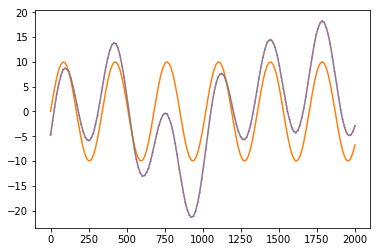

In [4]:
fig, ax = plt.subplots()
ax.errorbar(t, y, yerr=yerr, alpha=0.5)
ax.plot(t, y_true, color='r', alpha=0.5)
ax.plot(t, A * np.sin(2.0 * np.pi * t / P))

TODO - Our data set is comprised of three components.  A sinusodial planetary signal; correlated noise of stellar origin; uncorrelated 'white' intrumental noise.

## Let's fit the Data the usual way

In [5]:
class like():
    def __init__(self, t, y, yerr):
        self.y = y
        self.yerr = yerr
        self.t = t

    def model(self, params):
        return params[0] * np.sin(2.0 * np.pi * self.t / params[1])
        
    def __call__(self, params):
        if params[0] < 0:
            return -np.inf
        return np.sum(-0.5 * (y - self.model(params))**2 / yerr**2  )     
            
import emcee

lp = like(t, y, yerr)
initial = np.array([A, P])
print(initial)
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, lp)

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 2000)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);

[ 10. 340.]
Running burn-in...
Running production...


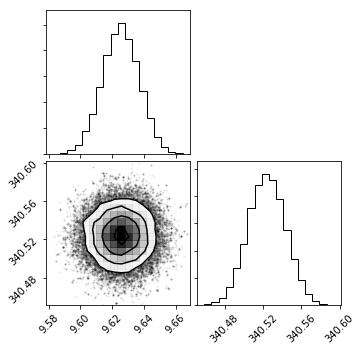

In [6]:
import corner
corner.corner(sampler.flatchain)
plt.show()

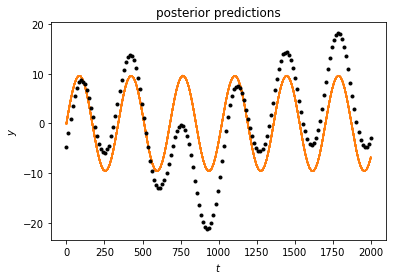

In [9]:
# Plot the data.
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
color = "#ff7f0e"
lp = like(t, y, yerr)
# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=53)]:
    
    mu = lp.model(s)
    plt.plot(t, mu, color=color, alpha=0.3)

plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("posterior predictions");

## Let's construct a Celerite model

In [10]:
import celerite
from celerite import terms

kernel = terms.RealTerm(log_a=np.log(np.var(y)), log_c=-np.log(10.0))
gp = celerite.GP(kernel, mean=model, fit_mean=True)
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -485.4945058101724


In [11]:
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    if params[2] < 0:
        return -np.inf
    return gp.log_likelihood(y) + lp

In [12]:
import emcee

initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);

Running burn-in...
Running production...


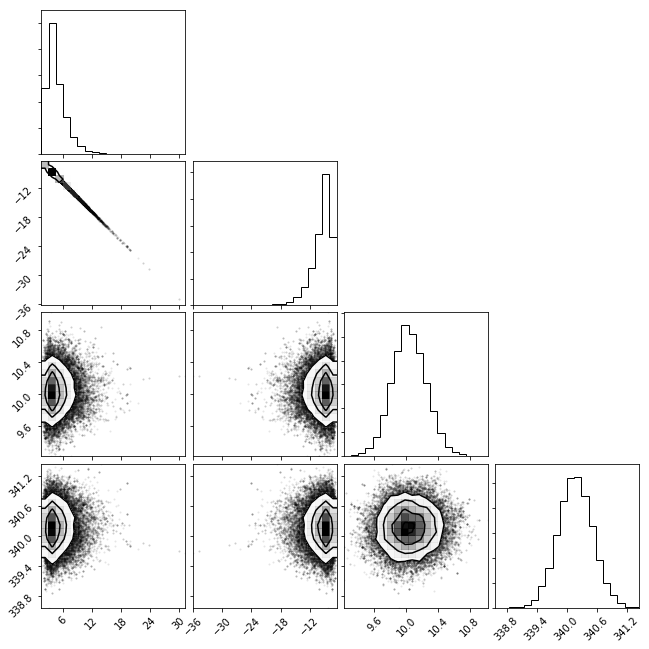

In [13]:
corner.corner(sampler.flatchain)
plt.show()

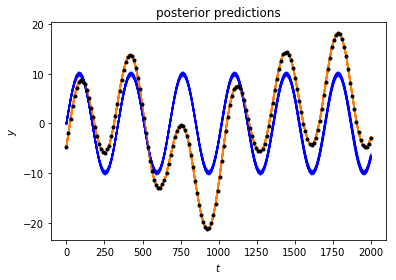

In [14]:
# Plot the data.
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

lp = like(t, y, yerr)
# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=53)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(y, t, return_cov=False)
    plt.plot(t, mu, color=color, alpha=0.3)
    mu = lp.model(s[2:])
    plt.plot(t, mu, color='b', alpha=0.3)

plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("posterior predictions");